## Cataracts Image Classification by CNN

In this notebook, we train a convolutional neural network (CNN) to classify images of human eyes as being normal or having a cataract. A cataract is a medical condition that can cause a decrease in vision or blindness. The data set used in this notebook is open source and comes from the Kaggle page "Cataract dataset" [https://www.kaggle.com/datasets/nandanp6/cataract-image-dataset]. 

In [1]:
#import data manipulation packages 
import pandas as pd 
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
import warnings
import PIL
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
#import deep learning tools 
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow
from tensorflow.keras.metrics import categorical_crossentropy

In [3]:
# Set the seed value for experiment reproducibility.
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')

## What is a cataract?

A cataract is a cloudy area in the lens of the eye that can cause a decrease in vision or completely blindness. Patients with cataract present with a white cloudy pupil. The cataract can often be detected by an examination with the naked eye. Below are two examples of a normal eye (left) and an eye with cataract (right). The opaque lens can typically be removed and replaced in an out-patient surgical proceedure. Cataract surgeries have a high success rate and have good outcomes for patient vision.

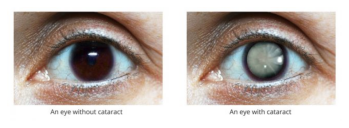

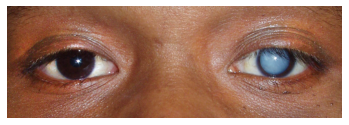

In [145]:
norm_directory = 'train/normal'
cat_directory = 'train/cataract'

cat_filename = os.listdir(cat_directory)[20]

cat_f = os.path.join(cat_directory,cat_filename)
cat_image = PIL.Image.open(cat_f)
plt.imshow(cat_image)
plt.axis('off')
plt.show()

cat_filename = os.listdir(cat_directory)[14]

cat_f = os.path.join(cat_directory,cat_filename)
cat_image = PIL.Image.open(cat_f)
plt.imshow(cat_image)
plt.axis('off')
plt.show()



## Understanding The Data

Below are examples of "normal" and "cataract" images from the data set in the left and right columns, respectfully. The data set is not clean in various ways: The images are taken in various light sources and have refletions of objects from the surroundings. The data set is composed of images likley scraped from the internet. As a result, some of the images have text or are photo shopped. The images are also taken at various dimensions and resolutions.

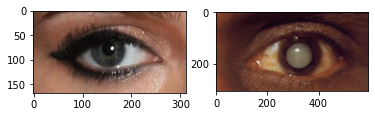

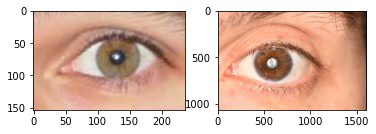

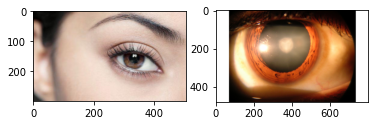

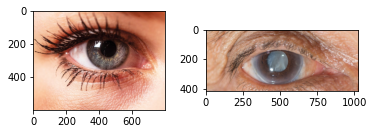

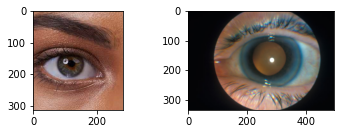

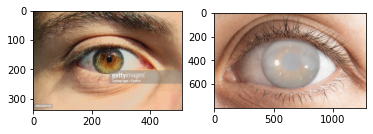

In [146]:
#import images

i = 0
for norm_fn, cat_fn in zip(os.listdir(norm_directory), os.listdir(cat_directory)):
    norm_f = os.path.join(norm_directory,norm_fn)
    norm_image = PIL.Image.open(norm_f)
    
    cat_f = os.path.join(cat_directory,cat_fn)
    cat_image = PIL.Image.open(cat_f)
    
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(norm_image)
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(cat_image)
    
    i+=1
    if i  > 5:
        break

In [147]:
print('train/normal: ' + str(len(os.listdir('train/normal'))))
print('test/normal: ' + str(len(os.listdir('test/normal'))))
print('train/cataract: ' + str(len(os.listdir('train/cataract'))))
print('test/cataract: ' + str(len(os.listdir('test/cataract'))))

print('Total: ' + str(len(os.listdir('train/normal')) + len(os.listdir('test/normal')) +
                       len(os.listdir('train/cataract')) + len(os.listdir('test/cataract'))))

train/normal: 246
test/normal: 60
train/cataract: 245
test/cataract: 61
Total: 612


## Preprocessing The Data

In this section, we collect all the images as numpy arrays into train and test lists. The lists are then randomized. The images are resized to be 200x200 pixels. One-hot encoding is used to encode the "normal" and "cataract" labels. 

In [184]:
#import all images into train and test arrays and grayscale counterparts
#resize images to be common shape
#make label arrays

train_dirs = ['train/normal', 'train/cataract']
test_dirs = ['test/normal', 'test/cataract']

train_L = []
test_L = []

train_g_L = []
test_g_L = []

m = 200

for directory in train_dirs:
    for filename in os.listdir(directory):
        f = os.path.join(directory,filename)
        image = PIL.Image.open(f)
        
        image = image.resize((m,m))
        
        train_L.append(np.array(image))
        train_g_L.append(np.array(image.convert('L')))
        
for directory in test_dirs:
    for filename in os.listdir(directory):
        f = os.path.join(directory,filename)
        image = PIL.Image.open(f)
        
        image = image.resize((m,m))
        
        test_L.append(np.array(image))
        test_g_L.append(np.array(image.convert('L')))

In [185]:
print('Train and test set sizes:')
print(len(train_L))
print(len(test_L))

print('\n')

print('Image shapes:')
print(train_L[0].shape)
print(train_g_L[0].shape)
print(test_L[0].shape)
print(test_g_L[0].shape)

Train and test set sizes:
491
121


Image shapes:
(200, 200, 3)
(200, 200)
(200, 200, 3)
(200, 200)


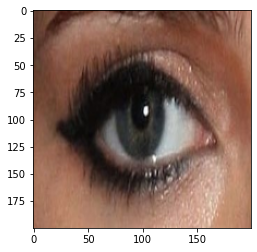

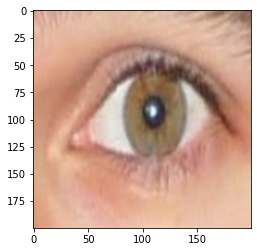

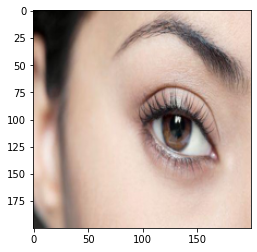

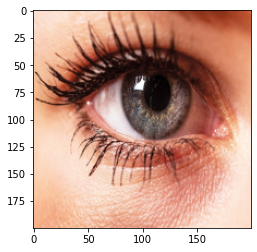

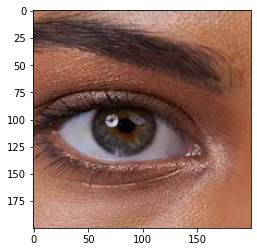

In [186]:
#examples of resized images

for i in range(5):
    a = train_L[i]
    plt.imshow(a)
    plt.show()

In [187]:
#make 1-hot encoded label arrays
#[0,1] = cataract, [1,0] = normal

y_train = [[1,0]]*len(os.listdir('train/normal')) + [[0,1]]*len(os.listdir('train/cataract'))
y_test = [[1,0]]*len(os.listdir('test/normal')) + [[0,1]]*len(os.listdir('test/cataract'))

In [188]:
#randomize then do train, test, validation split
#validaion set size chose to be roughly same size as test set

train_L, y_train = shuffle(train_L, y_train)
test_L, y_test = shuffle(test_L, y_test)

X_train = np.array(train_L)
X_test = np.array(test_L)

y_train = np.array(y_train)
y_test = np.array(y_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [189]:
#reshape numpy label arrays

y_train = y_train.reshape((-1,2))
y_val = y_val.reshape((-1,2))

In [190]:
#sanity check

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(328, 200, 200, 3)
(163, 200, 200, 3)
(328, 2)
(163, 2)


## Building a CNN

In [191]:
#build keras CNN model

model = keras.models.Sequential([
            keras.layers.Conv2D(32, 3, activation = 'relu', input_shape = (200,200,3)),
            keras.layers.MaxPooling2D(),
            keras.layers.Conv2D(32, 3, activation = 'relu'),
            keras.layers.MaxPooling2D(),
            keras.layers.Dropout(0.5),
            keras.layers.Flatten(),
            keras.layers.Dense(128, activation = 'relu'),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(2, activation = 'softmax')])

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
             )

callback = keras.callbacks.EarlyStopping(monitor = 'accuracy',
                                        patience = 3,
                                        restore_best_weights = True)

In [200]:
#train model

model.fit(X_train, y_train, epochs = 5, callbacks = callback) #validation_data = (X_val, y_val),

Epoch 1/5
11/11 [==============================] - 11s 1s/step - loss: 0.5865 - accuracy: 0.6829
Epoch 2/5
11/11 [==============================] - 13s 1s/step - loss: 0.5789 - accuracy: 0.7287
Epoch 3/5
11/11 [==============================] - 12s 1s/step - loss: 0.4704 - accuracy: 0.7195
Epoch 4/5
11/11 [==============================] - 11s 1s/step - loss: 0.4425 - accuracy: 0.7348
Epoch 5/5
11/11 [==============================] - 11s 993ms/step - loss: 0.3705 - accuracy: 0.8262


In [206]:
#check accuracy on test set

loss, accuracy = model.evaluate(X_test,y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

4/4 [==============================] - 1s 285ms/step - loss: 0.4673 - accuracy: 0.8678
Loss:  0.46730735898017883
Accuracy:  0.8677685856819153


In [207]:
#evaluate model on some training data

yhat = np.round(model.predict(X_train),2)

11/11 [==============================] - 3s 293ms/step


('Label: [1 0]', 'Prediction: [0.7 0.3]')


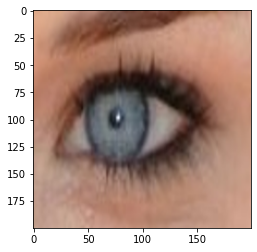

('Label: [1 0]', 'Prediction: [0.67 0.33]')


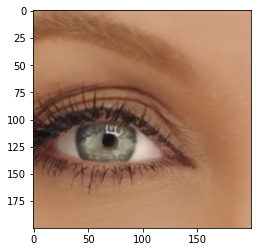

('Label: [1 0]', 'Prediction: [1. 0.]')


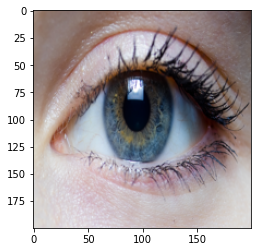

('Label: [0 1]', 'Prediction: [0.5 0.5]')


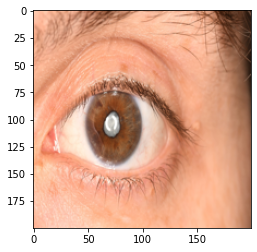

('Label: [0 1]', 'Prediction: [0.68 0.32]')


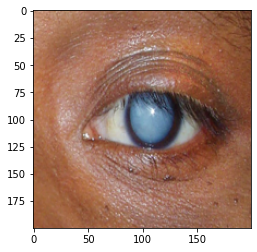

In [208]:
#Examples of labeled images and predictions
#Rerun cell for random selection of 5 images

X_train_new, y_train_new, yhat_new = shuffle(X_train, y_train, yhat)

for i in range(5):
    a = X_train_new[i]
    print(('Label: ' + str(y_train_new[i]), 'Prediction: ' + str(yhat_new[i])))
    plt.imshow(a)
    plt.show()

## CNN Hyperparameter Search

We use the Keras Tuner to choose the best CNN model architecture from a family of models. 

In [212]:
from kerastuner.tuners import RandomSearch
import keras_tuner

def build_model(hp):
    model = keras.Sequential()
    
    model.add(keras.layers.AveragePooling2D(6,3,input_shape = (200,200,3)))
    
    for i in range(hp.Int("Conv Layers", min_value = 0, max_value = 3)):
        model.add(keras.layers.Conv2D(hp.Choice(f"layer_{i}_filters", [16,32,64]), 3, activation = 'relu'))
        model.add(keras.layers.MaxPool2D(2,2))
        model.add(keras.layers.Dropout(0.5))
    
    model.add(keras.layers.MaxPool2D(2,2))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Flatten())
                  
    model.add(keras.layers.Dense(hp.Choice("Dense layer", [64, 128, 256, 512, 1024]), activation = 'relu'))
    
    model.add(keras.layers.Dense(2, activation = 'softmax'))
                  
    model.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
                  
    return model
    
tuner = RandomSearch(
        build_model,
        objective = 'val_loss',
        max_trials = 32,
        overwrite=True
)
                  
tuner.search(X_train, y_train, validation_data = (X_val, y_val), epochs = 10, batch_size = 32)                

Trial 32 Complete [00h 00m 13s]
val_loss: 0.6209588646888733

Best val_loss So Far: 0.3904353976249695
Total elapsed time: 00h 11m 16s
INFO:tensorflow:Oracle triggered exit


In [218]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
Conv Layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
Dense layer (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256, 512, 1024], 'ordered': True}
layer_0_filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
layer_1_filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
layer_2_filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}


In [214]:
best_model = tuner.get_best_models()[0]

In [215]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d (AverageP  (None, 65, 65, 3)        0         
 ooling2D)                                                       
                                                                 
 conv2d (Conv2D)             (None, 63, 63, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                        

In [216]:
loss, accuracy = best_model.evaluate(X_val,y_val)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

6/6 [==============================] - 1s 55ms/step - loss: 0.3904 - accuracy: 0.8405
Loss:  0.3904353976249695
Accuracy:  0.8404908180236816


In [217]:
loss, accuracy = best_model.evaluate(X_test,y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

4/4 [==============================] - 0s 61ms/step - loss: 0.2890 - accuracy: 0.9174
Loss:  0.288982629776001
Accuracy:  0.9173553586006165


## Conclusions

After hyperparameter tuning our CNN classifies eyes are being normal or having a cataract with more than 91% accuracy.